## Image Augmentation

Cats v Dogs 로 다음처럼 모델링 하고, 학습시켜본다.

4 convolutional layers with 32, 64, 128 and 128 convolutions

train for 100 epochs

https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [1]:
import os, zipfile, pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [4]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = keras.utils.get_file('cats_and_dogs_filtered.zip', url, extract=False)
extract_root = pathlib.Path('.')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)

In [6]:
IMG_SIZE = 150
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 20
SEED = 1337

In [10]:
base_dir = extract_root / 'cats_and_dogs_filtered'
train_dir = base_dir / 'train'
val_dir = base_dir / 'validation'

In [12]:
base_dir

PosixPath('cats_and_dogs_filtered')

In [13]:
train_dir

PosixPath('cats_and_dogs_filtered/train')

In [14]:
val_dir

PosixPath('cats_and_dogs_filtered/validation')

In [15]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 2000 files belonging to 2 classes.


In [16]:
val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1000 files belonging to 2 classes.


In [17]:
class_names = train_ds.class_names

In [18]:
class_names

['cats', 'dogs']

In [19]:
# 성능최적화를 위해서, 다음 배치를 백그라운드에서 미리 준비하라는 코드 작성

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

In [21]:
train_ds = train_ds.prefetch(AUTOTUNE)

In [22]:
val_ds = val_ds.prefetch(AUTOTUNE)

In [23]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1)
    ],
    name="data_augmentation",
)

In [24]:
def build_model(input_shape) :
  return keras.Sequential(
      [
          layers.Input(shape= input_shape ),
          data_augmentation,
          layers.Rescaling( 1.0 / 255.0 ),
          layers.Conv2D( 32, 3, activation='relu' ),
          layers.MaxPooling2D(2, 2),
          layers.Conv2D( 64, 3, activation='relu' ),
          layers.MaxPooling2D(2, 2),
          layers.Conv2D( 128, 3, activation='relu' ),
          layers.MaxPooling2D(2, 2),

          layers.Flatten(),
          layers.Dense( 512, activation='relu' ),
          layers.Dropout(0.2),
          layers.Dense( 1, activation='sigmoid' )
      ],
      name="simple_cnn"
  )

In [25]:
model = build_model(IMG_SHAPE)

In [26]:
model.summary()

Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile( optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss = keras.losses.BinaryCrossentropy(),
               metrics= [ keras.metrics.BinaryAccuracy ])

In [28]:
earyl_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [29]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[earyl_stop])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - binary_accuracy: 0.4844 - loss: 0.9658 - val_binary_accuracy: 0.5000 - val_loss: 0.6906
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - binary_accuracy: 0.5441 - loss: 0.6928 - val_binary_accuracy: 0.5810 - val_loss: 0.6722
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - binary_accuracy: 0.5966 - loss: 0.6746 - val_binary_accuracy: 0.6570 - val_loss: 0.6203
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - binary_accuracy: 0.6405 - loss: 0.6461 - val_binary_accuracy: 0.6380 - val_loss: 0.6693
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - binary_accuracy: 0.6537 - loss: 0.6187 - val_binary_accuracy: 0.6600 - val_loss: 0.6307
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - binary_accuracy: 0.6782 - loss: 0.6184 - val_binary_accuracy: 0.7160 - val_loss: 0.5673
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - binary_accuracy: 0.6973 - loss: 0.5990 - val_binary_accuracy: 0.5920 - val_loss:

In [30]:
model.evaluate(val_ds)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7924 - loss: 0.4834


[0.5672706365585327, 0.7160000205039978]

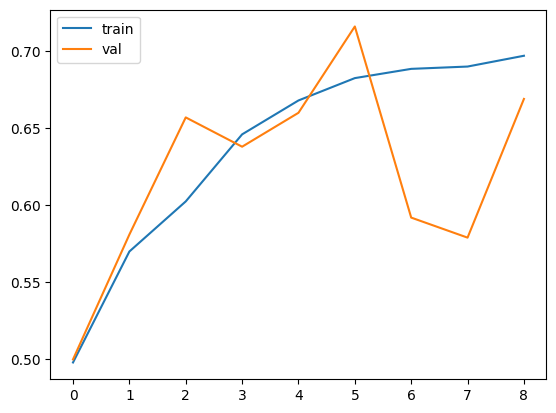

In [32]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()